# 👁️ Eye Diseases Classification using CNN & EfficientNetB3

## 📌 Introduction
This notebook builds a deep learning model to classify eye diseases from images.
It uses Convolutional Neural Networks (CNNs) and transfer learning with EfficientNetB3 to achieve accurate medical image classification.

## 📦 Import Libraries
We import essential libraries for data handling, visualization, and deep learning model development.

In [29]:
import numpy as np 
import pandas as pd 
import os 

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import (Conv2D , MaxPooling2D , Dense , 
                                    BatchNormalization , GlobalAveragePooling2D , Dropout ,Flatten)
from tensorflow.keras.optimizers import Adamax ,Adam
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
import tensorflow as tf
EfficientNetB3 = tf.keras.applications.EfficientNetB3
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix , classification_report 

import warnings 
warnings.filterwarnings("ignore")

## Dataset Loading
The dataset consists of labeled eye images organized into class folders.
Images are loaded using directory-based structure for efficient preprocessing.

In [30]:
base_folder_path = "/kaggle/input/eye-diseases-classification/dataset"
folders = os.listdir(base_folder_path)
images_path = []
labels = []
for folder in folders:
    folders_path = os.path.join(base_folder_path , folder)
    files_path = os.listdir(folders_path)
    for path in files_path:
        image_path = os.path.join(folders_path,path)
        images_path.append(image_path)
        labels.append(folder)
        

In [31]:
df = pd.DataFrame(data = {"Image Path" :images_path , "Labels" :labels})
df 

,Image Path,Labels
0,/kaggle/input/eye-diseases-classification/data...,glaucoma
1,/kaggle/input/eye-diseases-classification/data...,glaucoma
2,/kaggle/input/eye-diseases-classification/data...,glaucoma
3,/kaggle/input/eye-diseases-classification/data...,glaucoma
4,/kaggle/input/eye-diseases-classification/data...,glaucoma
...,...,...
4212,/kaggle/input/eye-diseases-classification/data...,cataract
4213,/kaggle/input/eye-diseases-classification/data...,cataract
4214,/kaggle/input/eye-diseases-classification/data...,cataract
4215,/kaggle/input/eye-diseases-classification/data...,cataract


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image Path  4217 non-null   object
 1   Labels      4217 non-null   object
dtypes: object(2)
memory usage: 66.0+ KB


### Split Data To Train,Test and Validation 

In [33]:
#Split data to train and dummy data
train_df , dummy_df = train_test_split(df,test_size=0.25,random_state=42,stratify=df["Labels"])

#split dummy data to test and validation data 
test_df , valid_df = train_test_split(dummy_df , test_size=0.5,random_state=42,stratify=dummy_df["Labels"])

print("shape of train data",train_df.shape)
print("shape of test data",test_df.shape)
print("shape of validation data",valid_df.shape)

shape of train data (3162, 2)
shape of test data (527, 2)
shape of validation data (528, 2)


In [34]:
print("Train Classes",train_df.Labels.value_counts())
print("\nTest Classes",test_df.Labels.value_counts())
print("\nValidation Classes",valid_df.Labels.value_counts())

Train Classes Labels
diabetic_retinopathy    823
normal                  805
cataract                779
glaucoma                755
Name: count, dtype: int64

Test Classes Labels
diabetic_retinopathy    137
normal                  134
cataract                130
glaucoma                126
Name: count, dtype: int64

Validation Classes Labels
diabetic_retinopathy    138
normal                  135
cataract                129
glaucoma                126
Name: count, dtype: int64


## Data Preprocessing & Augmentation
Image preprocessing includes rescaling pixel values and applying augmentation techniques
such as rotation, flipping, and zooming to improve model generalization.

In [35]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator()

batch_size = 32
target_size = (224, 224)


train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col="Image Path", y_col="Labels",
    target_size=target_size, color_mode="rgb",
    class_mode="categorical", batch_size=batch_size, shuffle=True, seed=4
)

valid_gen = test_datagen.flow_from_dataframe(
    valid_df, x_col="Image Path", y_col="Labels",
    target_size=target_size, color_mode="rgb",
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col="Image Path", y_col="Labels",
    target_size=target_size, color_mode="rgb",
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

Found 3162 validated image filenames belonging to 4 classes.
Found 528 validated image filenames belonging to 4 classes.
Found 527 validated image filenames belonging to 4 classes.


## CNN Model 

In [36]:
model = Sequential([
    # Block1
    Conv2D(16,kernel_size=(3,3),activation="relu",padding='same',input_shape=(224,224,3)),
    BatchNormalization(),
    Conv2D(16,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    Conv2D(16,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    Conv2D(16,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    #Block2
    Conv2D(32,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    Conv2D(32,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    Conv2D(32,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    Conv2D(32,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    #Block3
    Conv2D(64,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    Conv2D(64,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    Conv2D(64,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    Conv2D(64,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    #Block4
    Conv2D(128,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    Conv2D(128,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    Conv2D(128,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    Conv2D(128,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    #Block5
    Conv2D(1024,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    Conv2D(1024,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    Conv2D(1024,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    Conv2D(1024,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    #Block6
    Conv2D(2048,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    Conv2D(2048,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    Conv2D(2048,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    Conv2D(2048,kernel_size=(3,3),activation="relu",padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(4, activation='softmax')
    
]) 
model.compile(optimizer=Adamax(1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 224, 224, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 224, 224, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 224, 224, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 163,415,924 (623.38 MB)

 Trainable params: 163,388,404 (623.28 MB)

 Non-trainable params: 27,520 (107.50 KB)

## Model Training
The model is trained with callbacks such as EarlyStopping and ReduceLROnPlateau
to prevent overfitting and improve convergence.

In [37]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)

In [38]:
History = model.fit(train_gen,epochs=70,validation_data=valid_gen,callbacks=[early_stop,reduce_lr],verbose=1)

Epoch 1/70
99/99 ━━━━━━━━━━━━━━━━━━━━ 104s 831ms/step - accuracy: 0.4683 - loss: 1.4763 - val_accuracy: 0.2614 - val_loss: 2.7301 - learning_rate: 1.0000e-04
Epoch 2/70
99/99 ━━━━━━━━━━━━━━━━━━━━ 71s 708ms/step - accuracy: 0.5934 - loss: 0.9731 - val_accuracy: 0.2614 - val_loss: 4.2278 - learning_rate: 1.0000e-04
Epoch 3/70
99/99 ━━━━━━━━━━━━━━━━━━━━ 71s 710ms/step - accuracy: 0.6415 - loss: 0.8817 - val_accuracy: 0.2689 - val_loss: 6.2349 - learning_rate: 1.0000e-04
Epoch 4/70
99/99 ━━━━━━━━━━━━━━━━━━━━ 71s 711ms/step - accuracy: 0.6538 - loss: 0.8520 - val_accuracy: 0.4754 - val_loss: 1.7717 - learning_rate: 1.0000e-04
Epoch 5/70
99/99 ━━━━━━━━━━━━━━━━━━━━ 72s 721ms/step - accuracy: 0.6670 - loss: 0.8015 - val_accuracy: 0.6288 - val_loss: 1.0522 - learning_rate: 1.0000e-04
Epoch 6/70
99/99 ━━━━━━━━━━━━━━━━━━━━ 71s 716ms/step - accuracy: 0.6425 - loss: 0.8105 - val_accuracy: 0.7008 - val_loss: 0.7794 - learning_rate: 1.0000e-04
Epoch 7/70
99/99 ━━━━━━━━━━━━━━━━━━━━ 75s 749ms/step - ac

## Model Evaluation
Training and validation accuracy and loss are analyzed to evaluate model performance
and detect overfitting or underfitting.

In [39]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 365ms/step


## Confusion Matrix

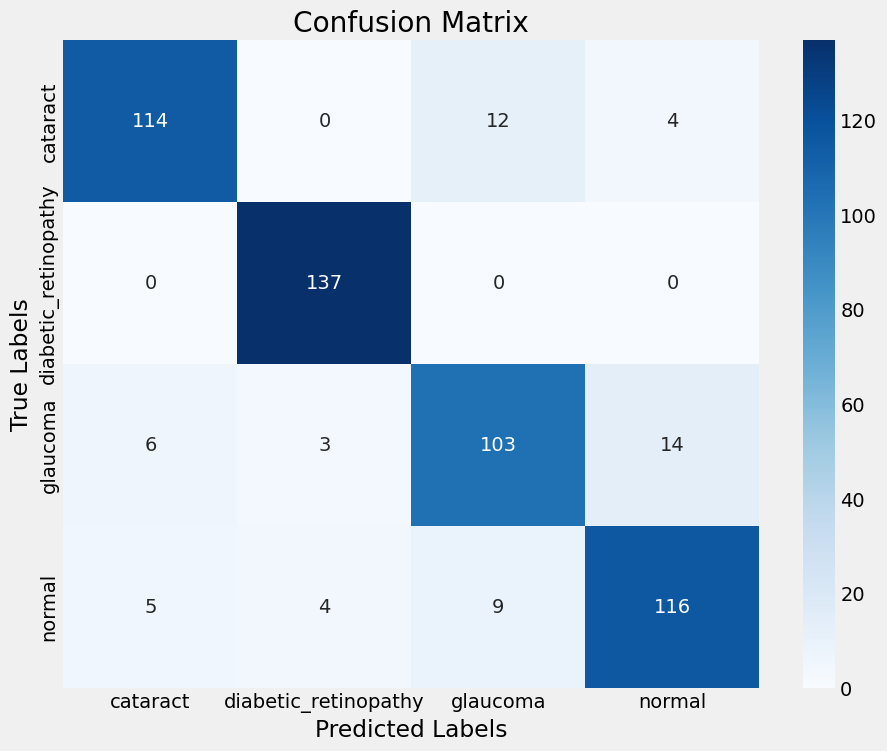

In [40]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=list(test_gen.class_indices.keys())
   ,yticklabels=list(test_gen.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [41]:
print("Train Accuracy : ",model.evaluate(train_gen)[1])
print("\nValid Accuracy : ",model.evaluate(valid_gen)[1])
print("\nTest Accuracy : ",model.evaluate(test_gen)[1])

99/99 ━━━━━━━━━━━━━━━━━━━━ 59s 588ms/step - accuracy: 0.9281 - loss: 0.1908
Train Accuracy :  0.9310563206672668
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.8863 - loss: 0.2812

Valid Accuracy :  0.8806818127632141
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 365ms/step - accuracy: 0.8978 - loss: 0.2446

Test Accuracy :  0.8918406367301941


In [42]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.91      0.88      0.89       130
diabetic_retinopathy       0.95      1.00      0.98       137
            glaucoma       0.83      0.82      0.82       126
              normal       0.87      0.87      0.87       134

            accuracy                           0.89       527
           macro avg       0.89      0.89      0.89       527
        weighted avg       0.89      0.89      0.89       527



## Training & Validation Performance

The training history plots show how the model performed across epochs.
By comparing training and validation loss and accuracy, we can evaluate model convergence, detect overfitting, and identify the best-performing epoch based on validation metrics.

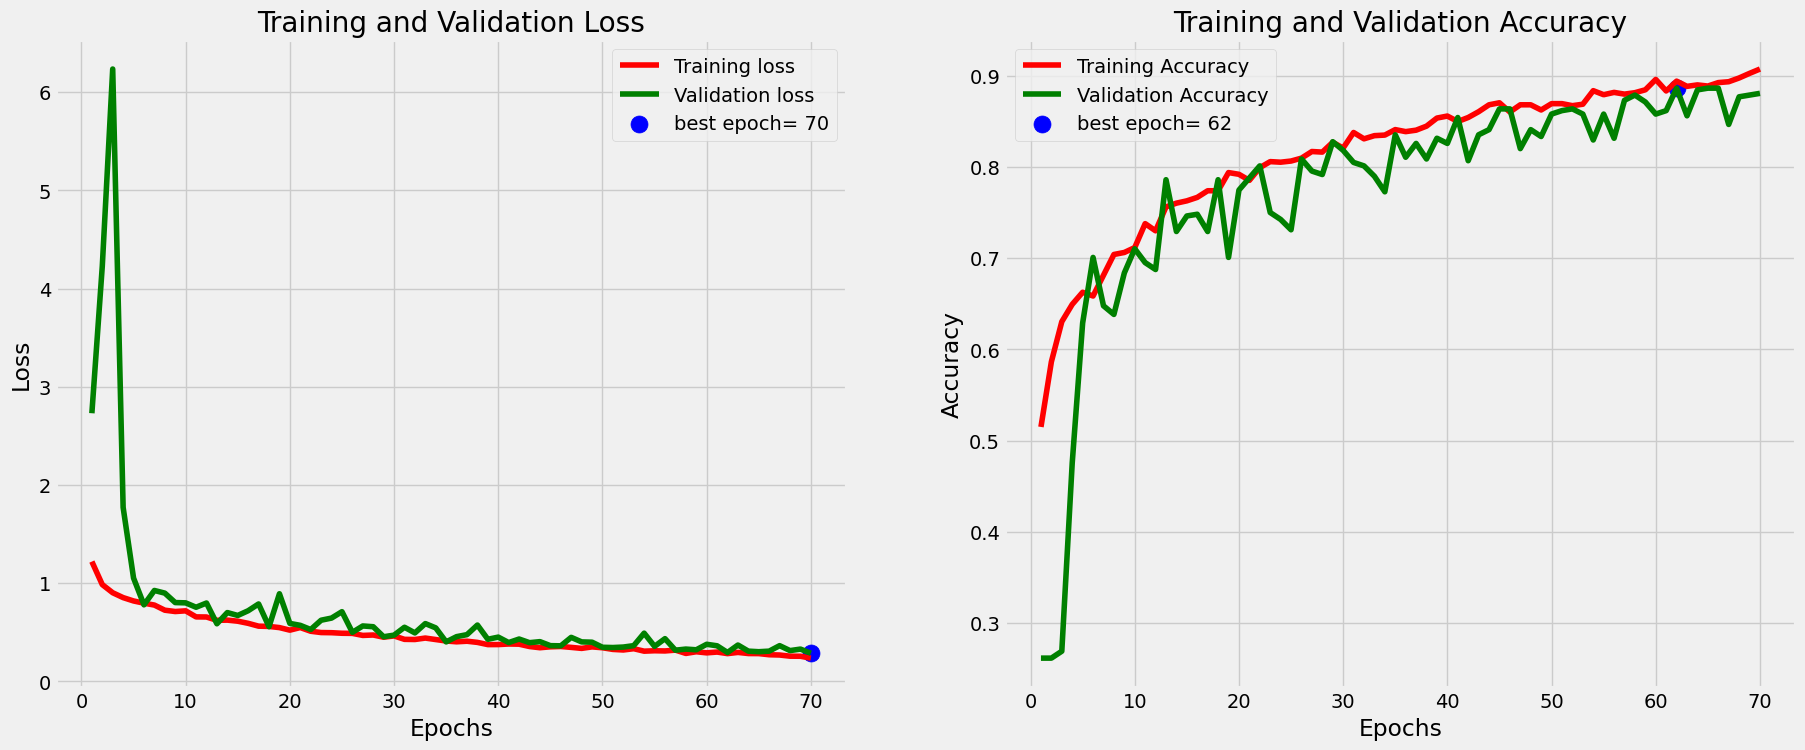

In [43]:
tr_acc = History.history['accuracy']
tr_loss = History.history['loss']
val_acc = History.history['val_accuracy']
val_loss = History.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## Fine-Tuning a Pretrained Model

In [44]:
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

batch_size = 16
target_size = (300,300)


train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col="Image Path", y_col="Labels",
    target_size=target_size, color_mode="rgb",
    class_mode="categorical", batch_size=batch_size, shuffle=True, seed=42
)

valid_gen = test_datagen.flow_from_dataframe(
    valid_df, x_col="Image Path", y_col="Labels",
    target_size=target_size, color_mode="rgb",
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col="Image Path", y_col="Labels",
    target_size=target_size, color_mode="rgb",
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

Found 3162 validated image filenames belonging to 4 classes.
Found 528 validated image filenames belonging to 4 classes.
Found 527 validated image filenames belonging to 4 classes.


In [45]:
base_model = EfficientNetB3(include_top=False, input_shape=(300,300,3), weights='imagenet')
base_model.trainable = False  # Freeze base

for layer in base_model.layers[-40:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(4, activation='softmax')(x)

pretrained_model = Model(inputs=base_model.input, outputs=outputs)
pretrained_model.compile(optimizer=Adamax(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)
]

In [47]:
history = pretrained_model.fit(
    train_gen,
    epochs=100,
    validation_data=valid_gen,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 174s 663ms/step - accuracy: 0.5255 - loss: 1.3486 - val_accuracy: 0.6913 - val_loss: 0.7952 - learning_rate: 1.0000e-04
Epoch 2/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 102s 516ms/step - accuracy: 0.7255 - loss: 0.7595 - val_accuracy: 0.7614 - val_loss: 0.6131 - learning_rate: 1.0000e-04
Epoch 3/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 103s 521ms/step - accuracy: 0.7728 - loss: 0.6387 - val_accuracy: 0.7879 - val_loss: 0.6019 - learning_rate: 1.0000e-04
Epoch 4/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 94s 474ms/step - accuracy: 0.7915 - loss: 0.5637 - val_accuracy: 0.7917 - val_loss: 0.5842 - learning_rate: 1.0000e-04
Epoch 5/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 101s 509ms/step - accuracy: 0.8056 - loss: 0.5433 - val_accuracy: 0.8220 - val_loss: 0.5159 - learning_rate: 1.0000e-04
Epoch 6/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 100s 504ms/step - accuracy: 0.8231 - loss: 0.4977 - val_accuracy: 0.8163 - val_loss: 0.5148 - learning_rate: 1.0000e-04
Epoch 7/100
198/198 ━━━━━━━━━━━━━━━

In [48]:
preds = pretrained_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 364ms/step


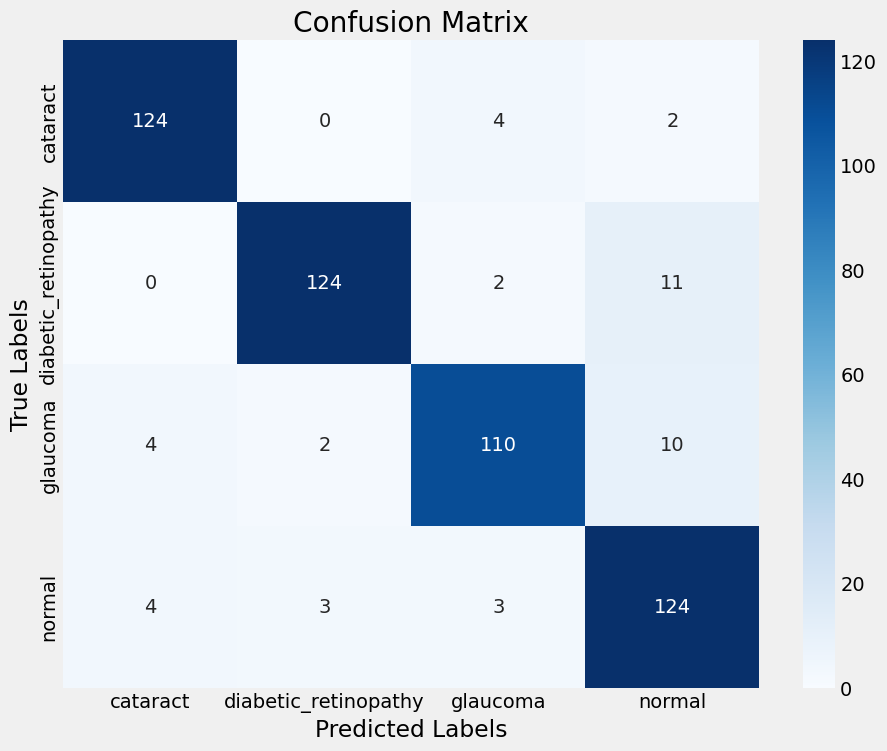

In [49]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=list(test_gen.class_indices.keys())
   ,yticklabels=list(test_gen.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [50]:
print("Train Accuracy : ",pretrained_model.evaluate(train_gen)[1])
print("\nValid Accuracy : ",pretrained_model.evaluate(valid_gen)[1])
print("\nTest Accuracy : ",pretrained_model.evaluate(test_gen)[1])

198/198 ━━━━━━━━━━━━━━━━━━━━ 83s 419ms/step - accuracy: 0.9757 - loss: 0.0661
Train Accuracy :  0.9775458574295044
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9001 - loss: 0.3193

Valid Accuracy :  0.8825757503509521
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 272ms/step - accuracy: 0.9237 - loss: 0.2629

Test Accuracy :  0.9146109819412231


In [51]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.94      0.95      0.95       130
diabetic_retinopathy       0.96      0.91      0.93       137
            glaucoma       0.92      0.87      0.90       126
              normal       0.84      0.93      0.88       134

            accuracy                           0.91       527
           macro avg       0.92      0.91      0.91       527
        weighted avg       0.92      0.91      0.91       527



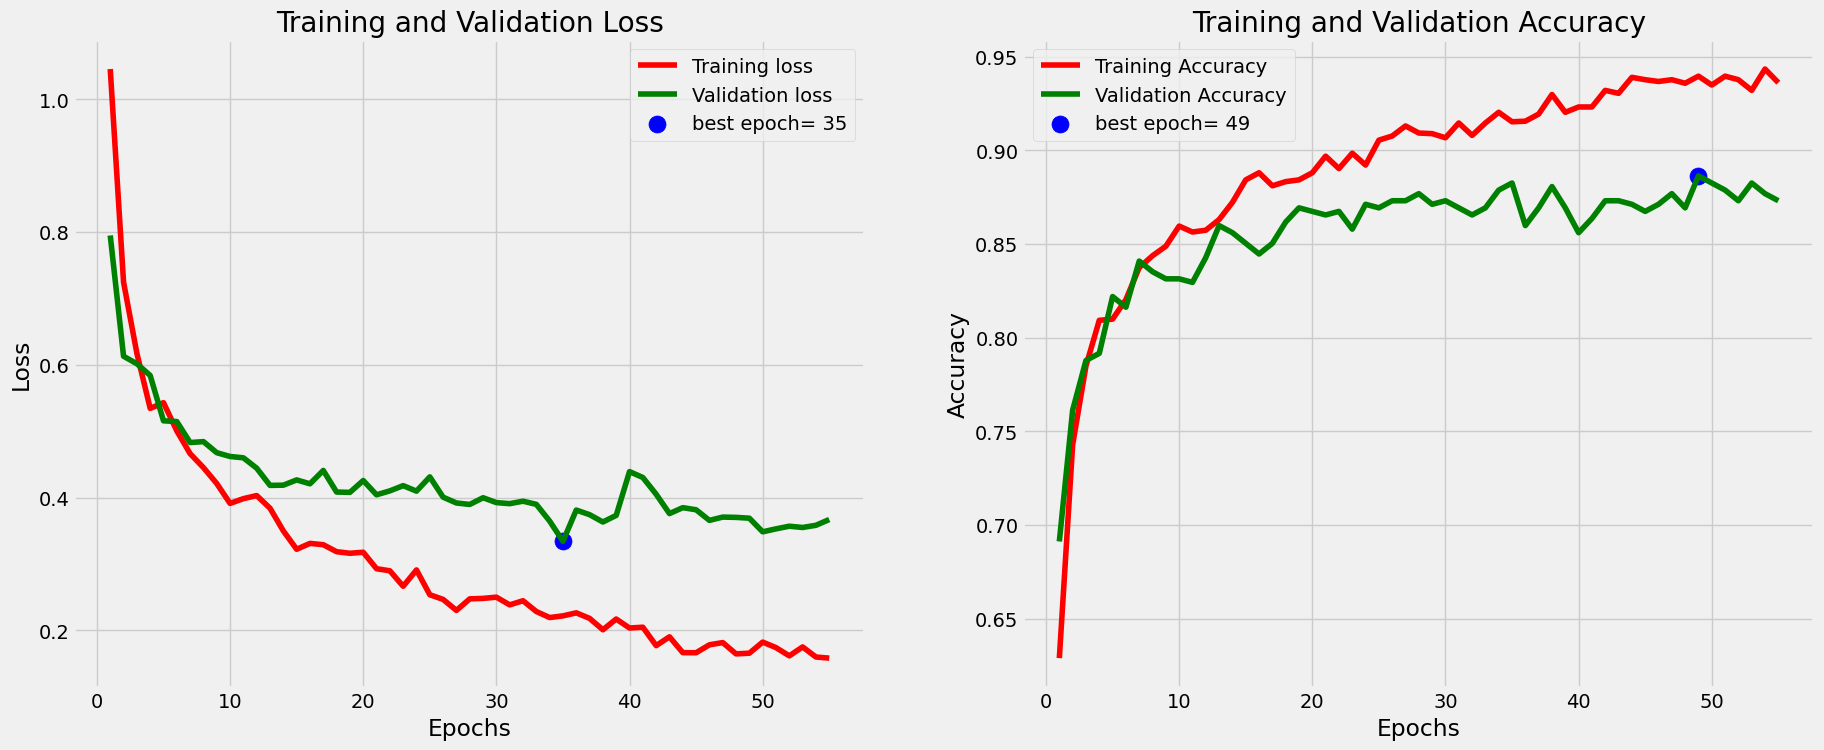

In [52]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


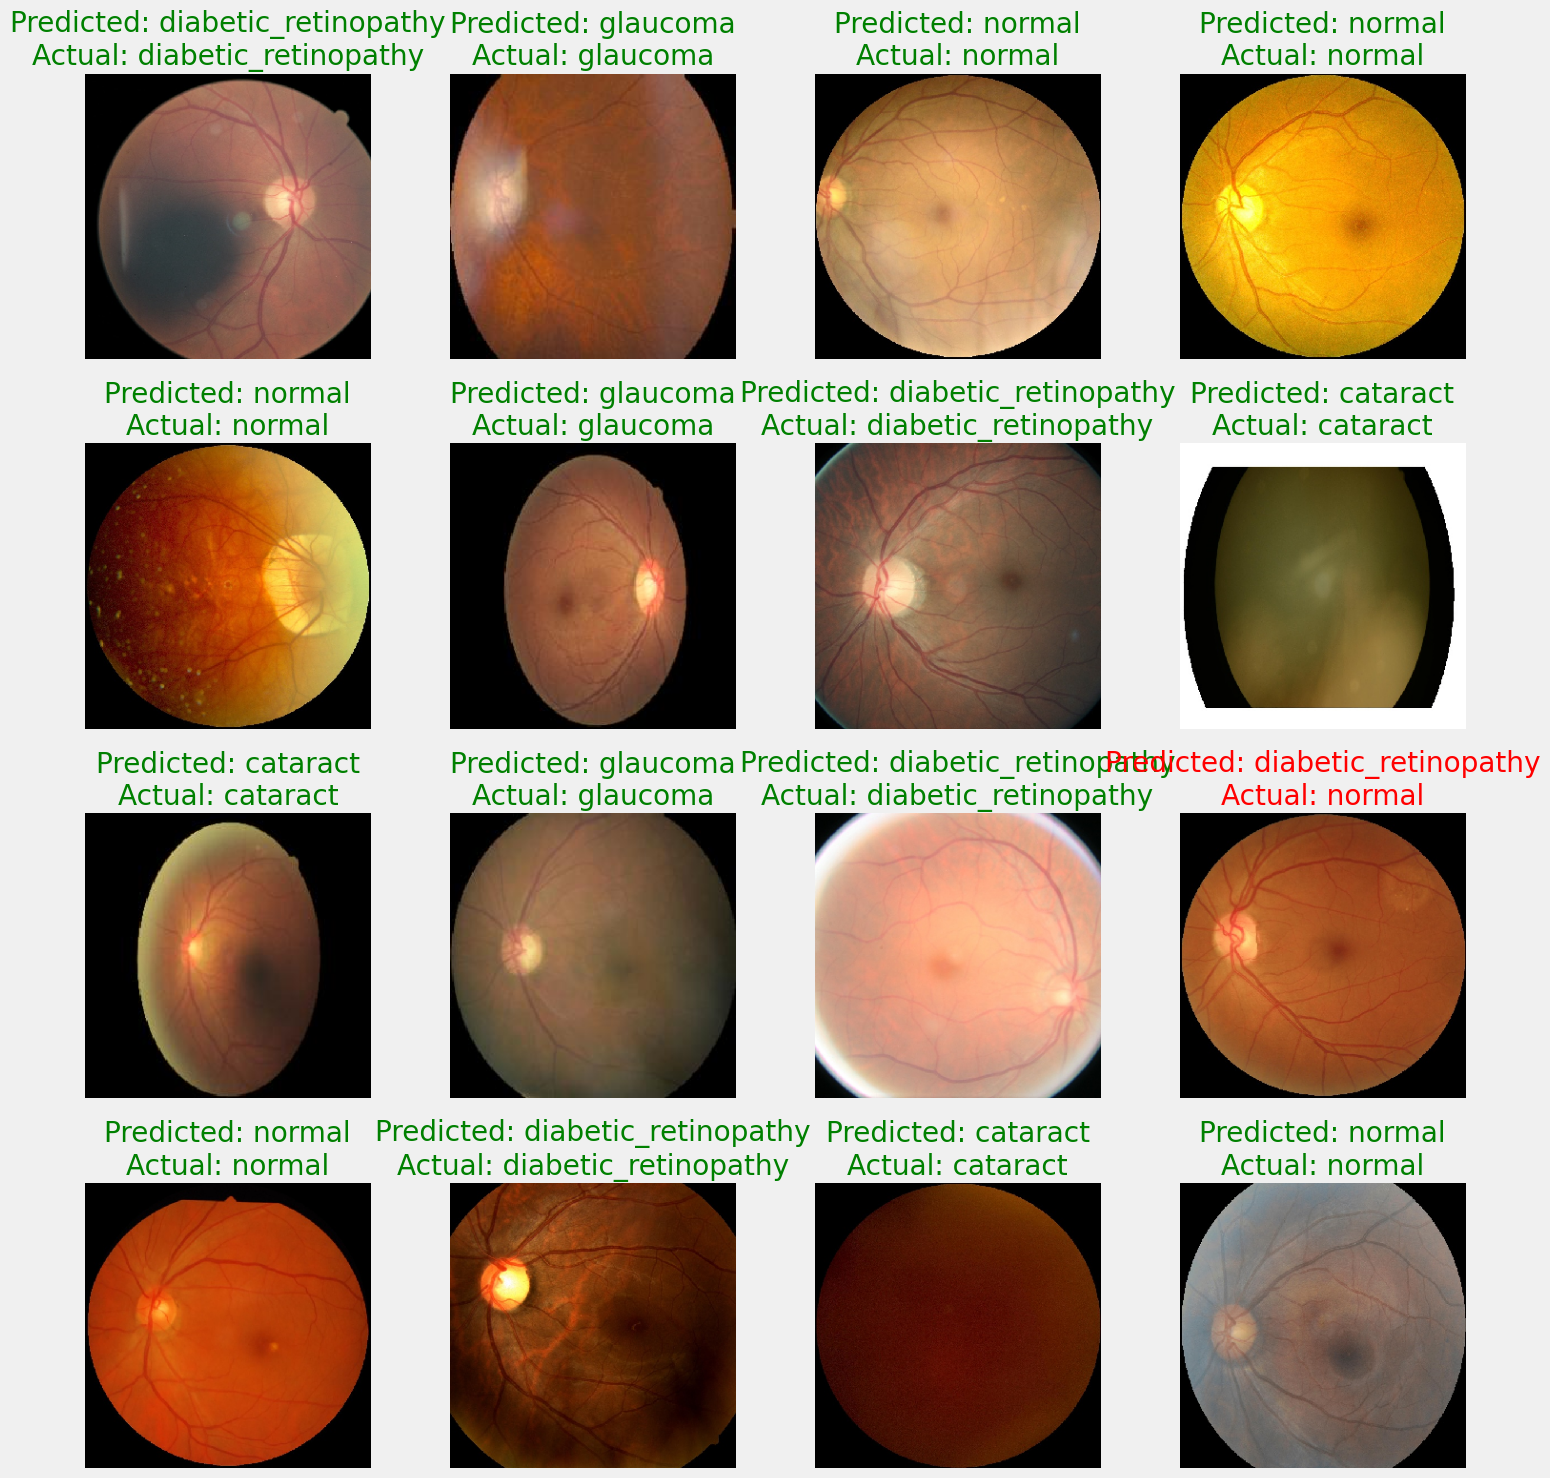

In [53]:
def plot_predictions(generator, model, num_images=16):
    images, labels = next(generator)  # get one batch
    predictions = model.predict(images)
    
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)
    class_names = list(generator.class_indices.keys())
    
    plt.figure(figsize=(15, 15))
    grid_size = int(np.ceil(np.sqrt(num_images)))
    
    for i in range(min(num_images, len(images))):  # ensure we don't exceed batch size
        ax = plt.subplot(grid_size, grid_size, i + 1)
        img = images[i]
        
        # scale if needed
        if img.max() > 1:
            img = img / 255.0
        
        plt.imshow(img)
        color = "green" if predicted_labels[i] == true_labels[i] else "red"
        plt.title(f"Predicted: {class_names[predicted_labels[i]]}\nActual: {class_names[true_labels[i]]}", color=color)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


plot_predictions(test_gen,pretrained_model, num_images=16)


## Save Model

In [54]:
pretrained_model.save('/kaggle/working/model.h5')     

##  Conclusion
This project demonstrates the effectiveness of transfer learning for medical image classification.
EfficientNetB3 provides strong performance while maintaining computational efficiency.